<a href="https://colab.research.google.com/github/kinjuk/finance-journal/blob/main/Portfolio-Optimizer-Sharpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  5 of 5 completed



Optimal weights:
Ticker
GLD   0.400000
QQQ   0.400000
SPY   0.100000
BND   0.050000
VTI   0.050000
dtype: float64

Portfolio summary:
Expected Annual Return   0.142862
Annual Volatility        0.131255
Sharpe Ratio             0.783683
Risk-free rate           0.040000
dtype: float64


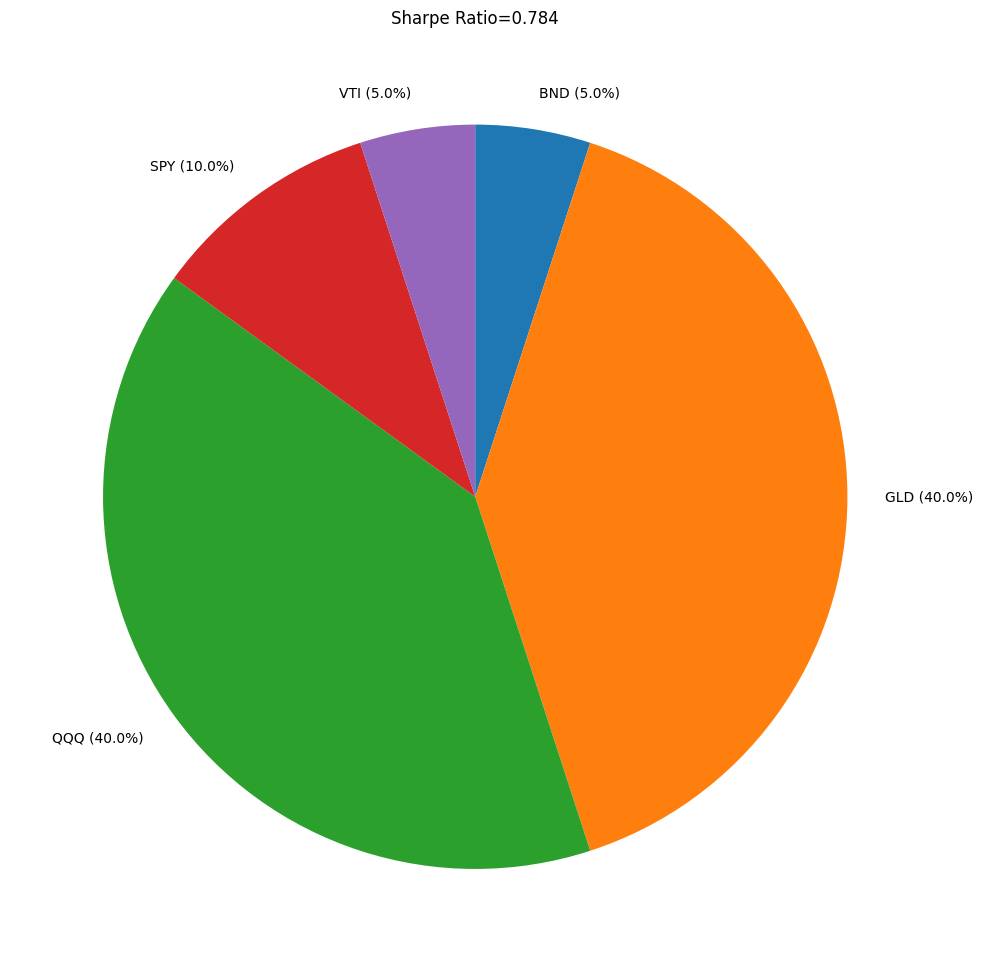

In [2]:
# PORTFOLIO OPTIMIZATION TOOL (SHARPE RATIO)

import os
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# INPUTS
tickers = ["SPY", "BND", "GLD", "QQQ", "VTI"]
start_date = "2015-01-01"
end_date = "2025-10-23"

trading_days = 252
rf = 0.04  # risk-free rate

# WEIGHTS
min_weight = 0.05
max_weight = 0.4

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# RAW DATA
prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"]

# if single ticker returns Series, convert to DataFrame
if isinstance(prices, pd.Series):
    prices = prices.to_frame(tickers[0])
prices = prices.sort_index().dropna(how="all")  # drop dates where all NaN
prices = prices.dropna(axis=1, how="all")       # drop tickers with no data
prices = prices.ffill().dropna() # forward fill then drop remaining NaNs

# NATURAL LOG RETURNS
log_returns = np.log(prices / prices.shift(1)).dropna()
returns = prices.pct_change().dropna()

# SUM ANNUAL RETURNS VIA NATURAL LOG
mu = np.exp(log_returns.mean() * trading_days) - 1

# STANDARD DEV INDIVIDUAL
std_individual = returns.std() * np.sqrt(trading_days)

# COV MATRIX
cov = returns.cov() * trading_days

# PERFORMANCE METRICS
def portfolio_performance(weights, mu, cov, rf):
    w = np.array(weights)
    port_return = float(np.dot(w, mu.values))
    port_vol = float(np.sqrt(w.T @ cov.values @ w))
    sharpe = (port_return - rf) / port_vol if port_vol > 0 else 0.0
    return port_return, port_vol, sharpe

def neg_sharpe(weights, mu, cov, rf):
    return -portfolio_performance(weights, mu, cov, rf)[2]

# BOUNDS
n = len(prices.columns)
bounds = tuple((min_weight, max_weight) for _ in range(n))
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
x0 = np.array([1.0 / n] * n)

# SHARPE OPTIMIZATION
opt = minimize(neg_sharpe, x0=x0, args=(mu, cov, rf),
               method="SLSQP", bounds=bounds, constraints=cons,
               options={'maxiter': 1000, 'ftol': 1e-9})

if not opt.success:
    raise RuntimeError(f"Optimization failed: {opt.message}")

opt_weights = pd.Series(opt.x, index=prices.columns)
opt_return, opt_vol, opt_sharpe = portfolio_performance(opt.x, mu, cov, rf)

# RESULTS
out_summary = pd.Series({
    "Expected Annual Return": opt_return,
    "Annual Volatility": opt_vol,
    "Sharpe Ratio": opt_sharpe,
    "Risk-free rate": rf
})
opt_weights.to_csv(os.path.join(results_dir, "optimal_weights.csv"))
out_summary.to_csv(os.path.join(results_dir, "portfolio_summary.csv"))

# SAVE INPUTS AND CALCULATIONS
mu.to_csv(os.path.join(results_dir, "annual_expected_returns.csv"))
std_individual.to_csv(os.path.join(results_dir, "annual_std_individual.csv"))
cov.to_csv(os.path.join(results_dir, "annual_cov_matrix.csv"))
prices.to_csv(os.path.join(results_dir, "prices.csv"))

# PRINT SUMMARY
pd.set_option('display.float_format', lambda x: f"{x:.6f}")
print("\nOptimal weights:")
print(opt_weights.sort_values(ascending=False))
print("\nPortfolio summary:")
print(out_summary)

# PIE CHART PLOT
labels = [f"{t} ({w*100:.1f}%)" for t, w in opt_weights.items()]
plt.figure(figsize=(10,10))
plt.pie(opt_weights.values, labels=labels, startangle=90, counterclock=False)
plt.title(f"Sharpe Ratio={opt_sharpe:.3f}")
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "allocation_pie.png"), dpi=300)
plt.show()
